In [1]:
!nvidia-smi

Sun Nov  2 16:22:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   28C    P8                1W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:

import sys
sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_121152/1344735116.py:15: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [3]:
import diffhydro as dh


eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[100,100,100]

In [4]:
U = dh.turbulence.init_turbulent_velocity(eq, 100, 1.0, 1.0,kmax=10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


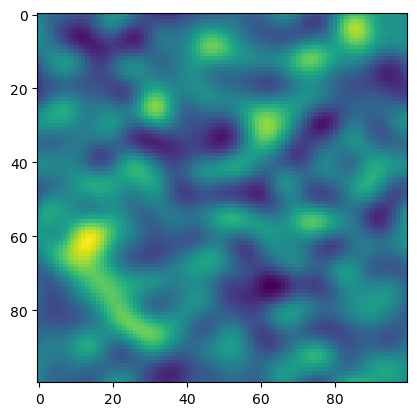

In [5]:
%pylab inline
imshow(U[3][30])

In [6]:
#np.save("turb_100x100x100",U)

In [6]:
ss = dh.signal_speed_Rusanov

solver = dh.HLLC(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=False)
#ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="MINMOD"), positivity=False)

hydro = dh.hydro(n_super_step=1000, fluxes=[cf],forces=[],use_mol=True, use_ctu=False, integrator="SSPRK3") 

using CTU? False


In [7]:
params = {}
output = hydro.evolve(U,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>]
using CTU? False


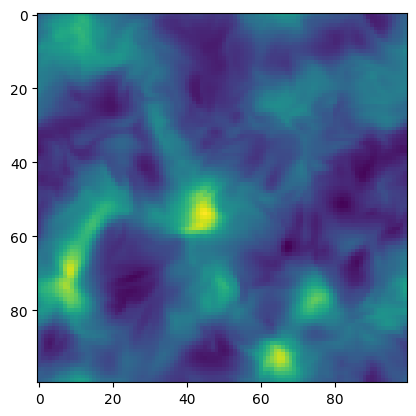

In [8]:
imshow(output[0][0][30])

In [9]:
TF = dh.turbulence.TurbulentForce(eq)

In [10]:
hydro = dh.hydro(n_super_step=1000, fluxes=[cf],forces=[TF],use_mol=True, use_ctu=False, integrator="SSPRK3") 

using CTU? False


In [11]:
params = {}
output = hydro.evolve(U,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


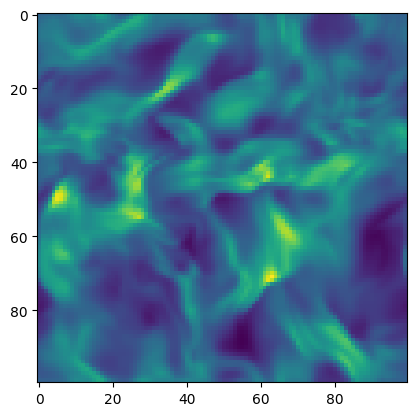

In [12]:
imshow(output[0][0][30]) #cool!